In [3]:
!pip install open3d

  Using cached dash-3.0.4-py3-none-any.whl.metadata (10 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached configargparse-1.7.1-py3-none-any.whl.metadata (24 kB)
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached werkzeug-3.0.6-py3-none-any.whl.metadata (3.7 kB)
  Using cached retrying-1.3.4-py3-none-any.whl.metadata (6.9 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
   ---------------------------------------- 0.0/69.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/69.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/69.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/69.2 MB 262.6 kB/s eta 0:04:24
   ---------------------------------------- 0.0/69.2 MB 262.6 kB/s eta 0:04:24
   ---------------------------------------- 0.0/69.2 MB 262.6 kB/s eta 0:04:24
   ---------------------------------

In [4]:
# KITTI-360 Semantic Data Analysis for HMM/Smoothing Research
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
from pathlib import Path
from collections import defaultdict, Counter
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("🔍 KITTI-360 Semantic Data Analysis")
print("===================================")
print("Goal: Understand data structure and applicability to HMM/Smoothing methods\n")

🔍 KITTI-360 Semantic Data Analysis
Goal: Understand data structure and applicability to HMM/Smoothing methods



In [11]:
# %%
# =============================================================================
# 1. DATASET STRUCTURE EXPLORATION
# =============================================================================

data_path = Path(r"C:\Users\caleb\OneDrive\Desktop\KITTI_3D\data_3d_semantics\data_3d_semantics\train")

# Discover all sequences

# Total sequence found: 9

sequences = sorted([d.name for d in data_path.iterdir() if d.is_dir()])
print(f"Total sequences found: {len(sequences)}")
print("Sequences:", sequences[:5], "..." if len(sequences) > 5 else "")

Total sequences found: 9
Sequences: ['2013_05_28_drive_0000_sync', '2013_05_28_drive_0002_sync', '2013_05_28_drive_0003_sync', '2013_05_28_drive_0004_sync', '2013_05_28_drive_0005_sync'] ...


In [21]:
# Analyze structure of each sequence

# Sequence Statistics:
# Average static files per sequence: 33.3
# Average dynamic files per sequence: 33.3
# Total static files: 300
# Total dynamic files: 300
# Average file size: 73.9 MB



sequence_info = {}

for seq_name in tqdm(sequences, desc="Analyzing sequences"):
    seq_path = data_path / seq_name
    static_dir = seq_path / "static"
    dynamic_dir = seq_path / "dynamic"
    
    info = {
        'name': seq_name,
        'has_static': static_dir.exists(),
        'has_dynamic': dynamic_dir.exists(),
        'static_files': len(list(static_dir.glob("*.ply"))) if static_dir.exists() else 0,
        'dynamic_files': len(list(dynamic_dir.glob("*.ply"))) if dynamic_dir.exists() else 0,
    }
    
# Get file size info for first few files
    if static_dir.exists():
        static_files = list(static_dir.glob("*.ply"))
        if static_files:
            sample_file = static_files[0]
            info['sample_file_size_mb'] = sample_file.stat().st_size / 1024 / 1024
            info['sample_filename'] = sample_file.name
    
    sequence_info[seq_name] = info
    
# Convert to DataFrame for analysis
df_sequences = pd.DataFrame(sequence_info.values())
print(f"\n Sequence Statistics:")
print(f"   Average static files per sequence: {df_sequences['static_files'].mean():.1f}")
print(f"   Average dynamic files per sequence: {df_sequences['dynamic_files'].mean():.1f}")
print(f"   Total static files: {df_sequences['static_files'].sum()}")
print(f"   Total dynamic files: {df_sequences['dynamic_files'].sum()}")
print(f"   Average file size: {df_sequences['sample_file_size_mb'].mean():.1f} MB")
    

Analyzing sequences: 100%|██████████| 9/9 [00:00<00:00, 129.96it/s]


📊 Sequence Statistics:
   Average static files per sequence: 33.3
   Average dynamic files per sequence: 33.3
   Total static files: 300
   Total dynamic files: 300
   Average file size: 73.9 MB


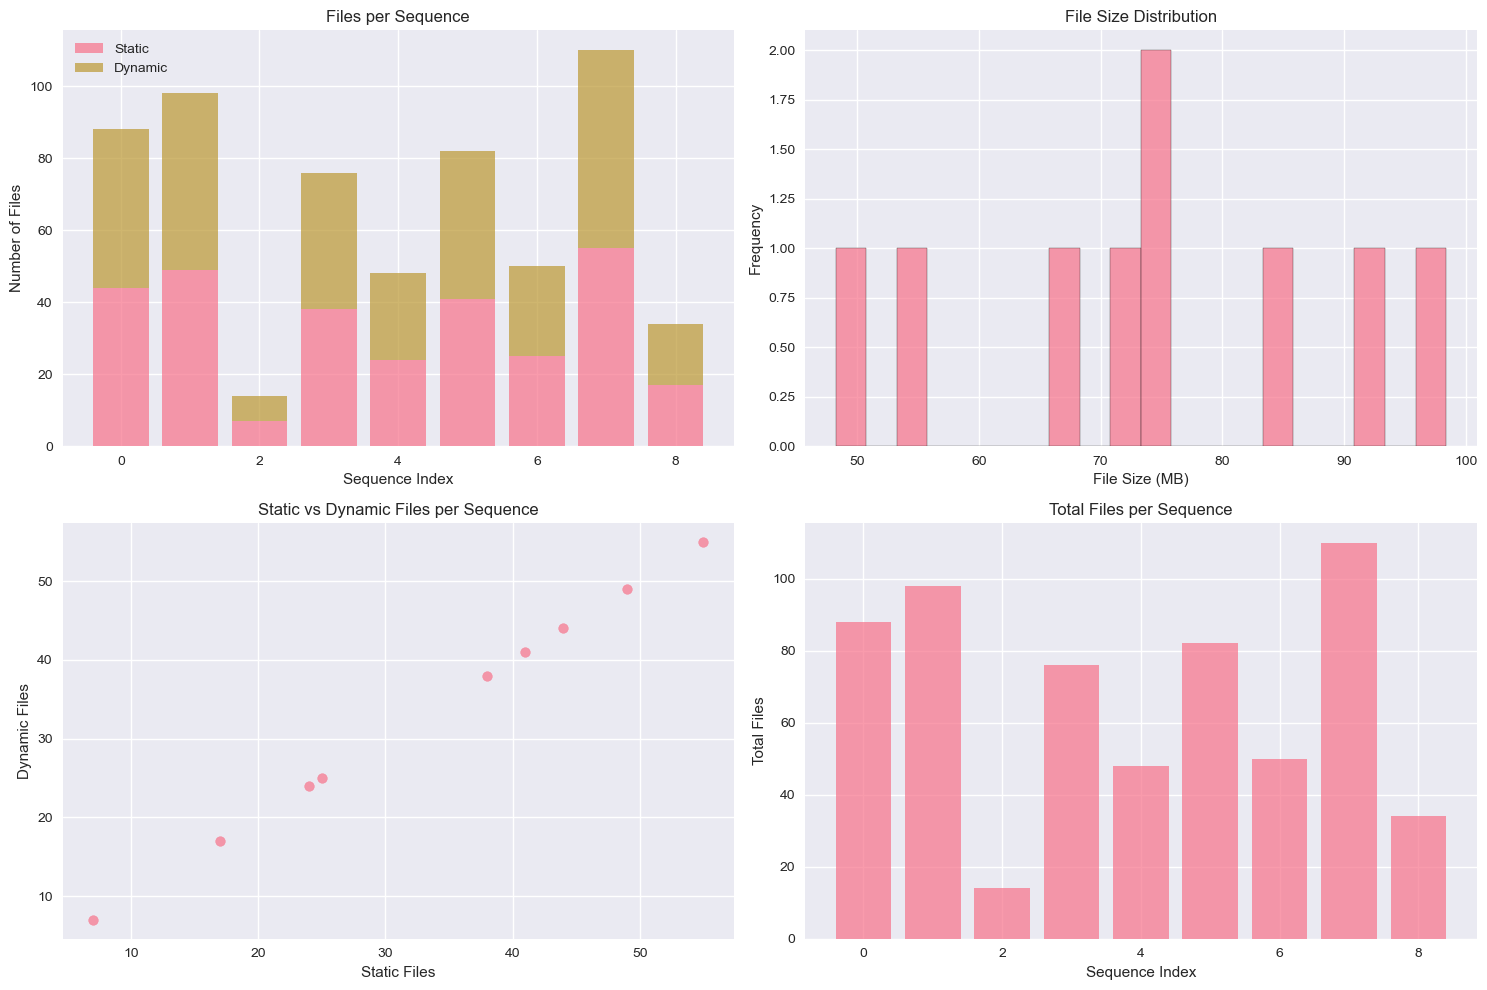

In [25]:
# Visualize sequence structure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Number of files per sequence
axes[0,0].bar(range(len(df_sequences)), df_sequences['static_files'], alpha=0.7, label='Static')
axes[0,0].bar(range(len(df_sequences)), df_sequences['dynamic_files'], alpha=0.7, label='Dynamic', bottom=df_sequences['static_files'])
axes[0,0].set_xlabel('Sequence Index')
axes[0,0].set_ylabel('Number of Files')
axes[0,0].set_title('Files per Sequence')
axes[0,0].legend()

# File size distribution
axes[0,1].hist(df_sequences['sample_file_size_mb'].dropna(), bins=20, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('File Size (MB)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('File Size Distribution')

# Static vs Dynamic files
axes[1,0].scatter(df_sequences['static_files'], df_sequences['dynamic_files'], alpha=0.7)
axes[1,0].set_xlabel('Static Files')
axes[1,0].set_ylabel('Dynamic Files')
axes[1,0].set_title('Static vs Dynamic Files per Sequence')

# Total files per sequence
total_files = df_sequences['static_files'] + df_sequences['dynamic_files']
axes[1,1].bar(range(len(total_files)), total_files, alpha=0.7)
axes[1,1].set_xlabel('Sequence Index')
axes[1,1].set_ylabel('Total Files')
axes[1,1].set_title('Total Files per Sequence')

plt.tight_layout()
plt.show()

📊 Temporal Analysis for 2013_05_28_drive_0000_sync:
   Files analyzed: 30
   Frame range: 2 - 7791
   Total frame span: 7789
   Average frame span per file: 271.8
   Frame span std: 94.5
   Min/Max frame span: 167 / 651
   Temporal gaps: 0 (avg: 0.0 frames)
   Temporal overlaps: 29 (avg: 12.6 frames)
   Data redundancy ratio: 1.05x (higher = more overlap)

🔗 TEMPORAL CONTINUITY ANALYSIS:
   This is CRUCIAL for HMM/Smoothing - we need continuous sequences!
   Found 1 continuous segments:
     Segment 1: 30 files, frames 2-7791 (duration: 7789)
   🎯 BEST for HMM: Segment with 30 files, 7789 frames
      This gives us 7789 timesteps for temporal modeling!


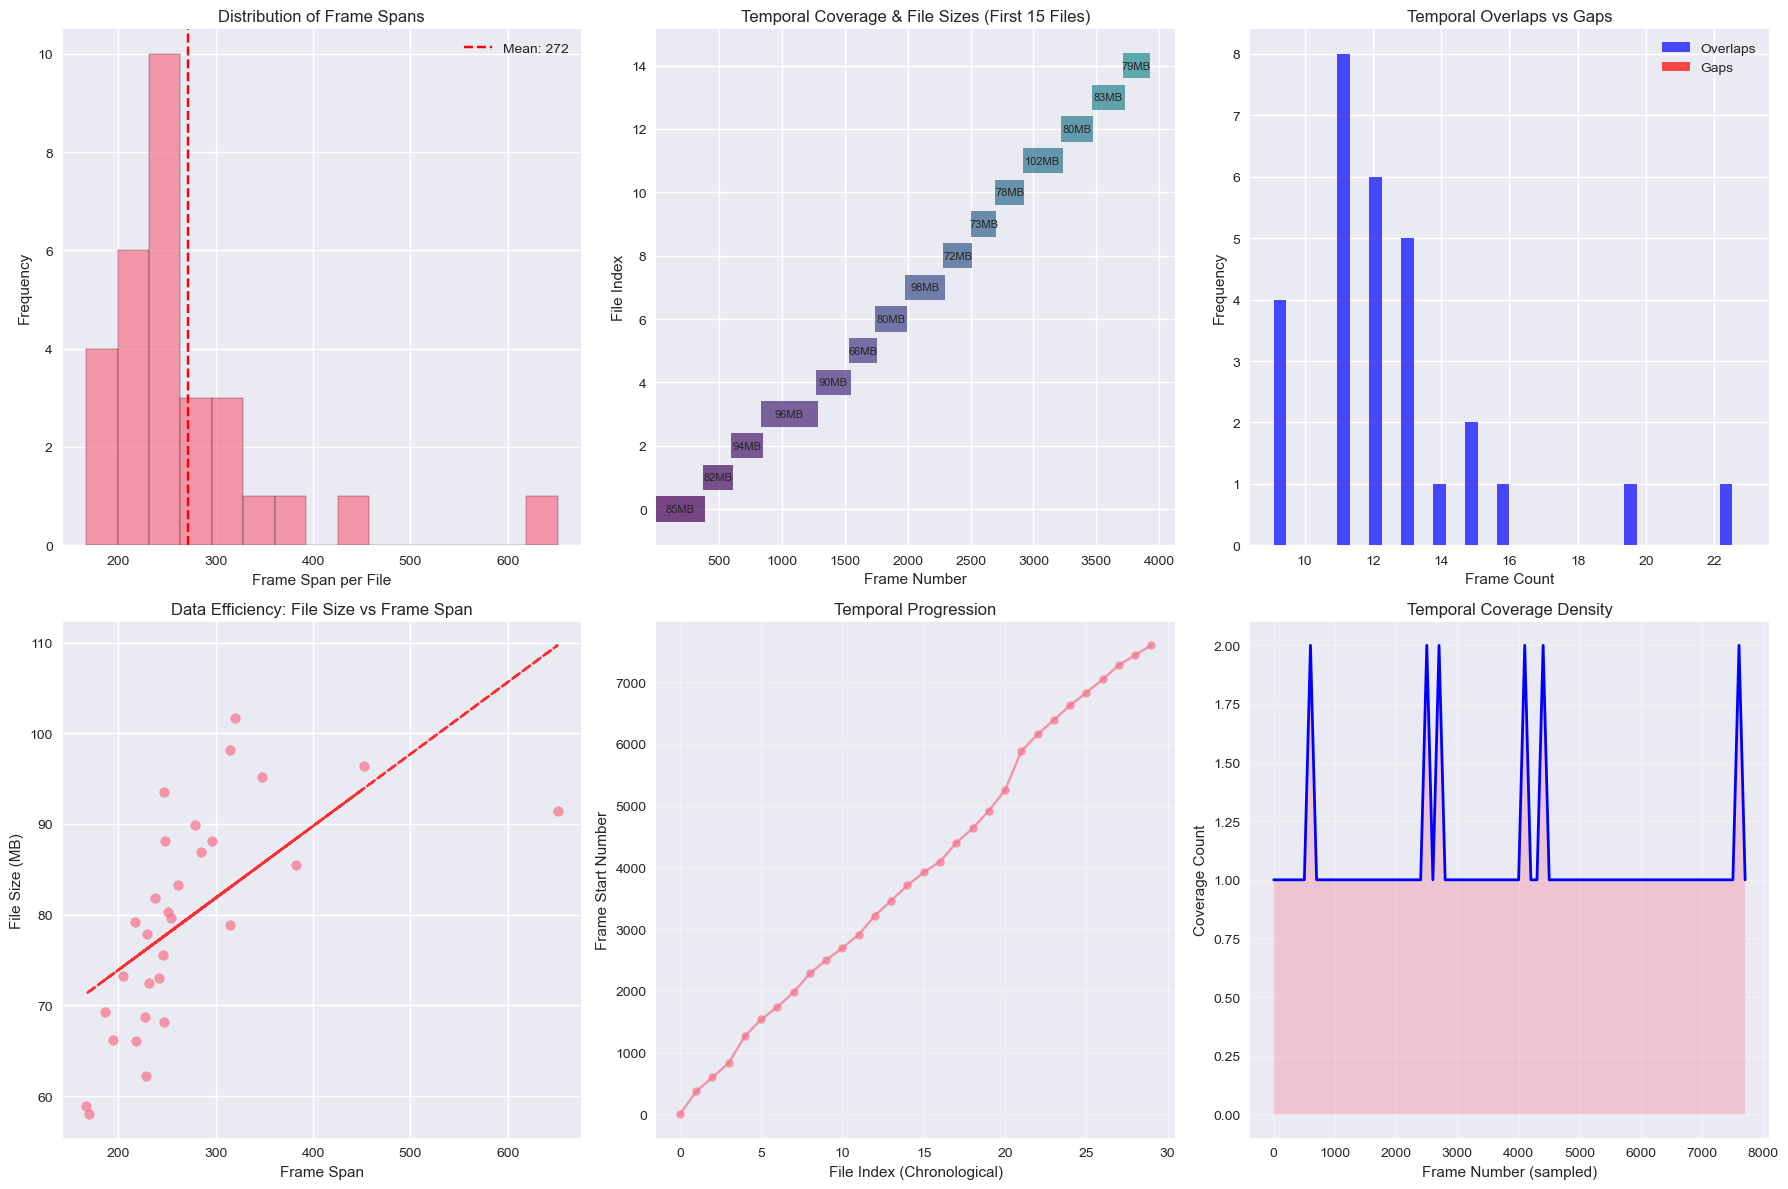


🎯 HMM/SMOOTHING APPLICABILITY ASSESSMENT:
   ✅ Temporal structure: EXCELLENT
      - Continuous sequences available: 1 segments
      - Longest sequence: 7789 frames
      - Sufficient for temporal modeling: YES
   ✅ Data density: MEDIUM
      - Redundancy ratio: 1.05x
      - Multiple observations per timeframe: YES
   📊 Recommendation: PROCEED - Good for HMM/Smoothing


In [35]:
# =============================================================================
# 2. TEMPORAL STRUCTURE ANALYSIS
# =============================================================================

def analyze_temporal_structure(sequence_name, max_files=20):
    """Analyze temporal structure of a sequence"""
    seq_path = data_path / sequence_name
    static_dir = seq_path / "static"
    
    if not static_dir.exists():
        return None
    
    # Get all PLY files
    ply_files = sorted(list(static_dir.glob("*.ply")))[:max_files]
    
    temporal_info = []
    for ply_file in ply_files:
        # Parse filename to extract timestamp/frame info
        # Format: XXXXXXXX_YYYYYYYYYY.ply (start_frame_end_frame or similar)
        parts = ply_file.stem.split('_')
        if len(parts) >= 2:
            try:
                frame1 = int(parts[0])
                frame2 = int(parts[1])
                temporal_info.append({
                    'filename': ply_file.name,
                    'frame1': frame1,
                    'frame2': frame2,
                    'frame_span': frame2 - frame1,
                    'file_size_mb': ply_file.stat().st_size / 1024 / 1024
                })
            except ValueError:
                continue
    
    return temporal_info

# Analyze temporal structure for first sequence
sample_sequence = sequences[0]
temporal_data = analyze_temporal_structure(sample_sequence, max_files=30)

if temporal_data:
    df_temporal = pd.DataFrame(temporal_data)
    
    print(f"📊 Temporal Analysis for {sample_sequence}:")
    print(f"   Files analyzed: {len(df_temporal)}")
    print(f"   Frame range: {df_temporal['frame1'].min()} - {df_temporal['frame2'].max()}")
    print(f"   Total frame span: {df_temporal['frame2'].max() - df_temporal['frame1'].min()}")
    print(f"   Average frame span per file: {df_temporal['frame_span'].mean():.1f}")
    print(f"   Frame span std: {df_temporal['frame_span'].std():.1f}")
    print(f"   Min/Max frame span: {df_temporal['frame_span'].min()} / {df_temporal['frame_span'].max()}")
    
    # Check for temporal overlap/gaps
    df_temporal_sorted = df_temporal.sort_values('frame1')
    gaps = []
    overlaps = []
    
    for i in range(len(df_temporal_sorted) - 1):
        current_end = df_temporal_sorted.iloc[i]['frame2']
        next_start = df_temporal_sorted.iloc[i + 1]['frame1']
        
        if next_start > current_end:
            gaps.append(next_start - current_end)
        elif next_start < current_end:
            overlaps.append(current_end - next_start)
    
    print(f"   Temporal gaps: {len(gaps)} (avg: {np.mean(gaps) if gaps else 0:.1f} frames)")
    print(f"   Temporal overlaps: {len(overlaps)} (avg: {np.mean(overlaps) if overlaps else 0:.1f} frames)")
    
    # Calculate coverage efficiency
    total_unique_frames = df_temporal['frame2'].max() - df_temporal['frame1'].min()
    total_frame_spans = df_temporal['frame_span'].sum()
    redundancy_ratio = total_frame_spans / total_unique_frames
    print(f"   Data redundancy ratio: {redundancy_ratio:.2f}x (higher = more overlap)")
    
    # Identify continuous segments
    print(f"\n🔗 TEMPORAL CONTINUITY ANALYSIS:")
    print("   This is CRUCIAL for HMM/Smoothing - we need continuous sequences!")
    
    # Sort by start frame and analyze continuity
    df_sorted = df_temporal.sort_values('frame1')
    
    # Find potential continuous sequences
    continuous_segments = []
    current_segment = [0]  # Start with first file
    
    for i in range(1, len(df_sorted)):
        prev_end = df_sorted.iloc[i-1]['frame2']
        curr_start = df_sorted.iloc[i]['frame1']
        
        # If there's overlap or small gap (≤ 50 frames), consider it continuous
        if curr_start <= prev_end + 50:
            current_segment.append(i)
        else:
            # End current segment, start new one
            if len(current_segment) > 1:
                continuous_segments.append(current_segment)
            current_segment = [i]
    
    # Don't forget the last segment
    if len(current_segment) > 1:
        continuous_segments.append(current_segment)
    
    print(f"   Found {len(continuous_segments)} continuous segments:")
    for j, segment in enumerate(continuous_segments):
        start_frame = df_sorted.iloc[segment[0]]['frame1']
        end_frame = df_sorted.iloc[segment[-1]]['frame2']
        duration = end_frame - start_frame
        print(f"     Segment {j+1}: {len(segment)} files, frames {start_frame}-{end_frame} (duration: {duration})")
        
    # Calculate the longest continuous sequence
    if continuous_segments:
        longest_segment = max(continuous_segments, key=len)
        longest_start = df_sorted.iloc[longest_segment[0]]['frame1']
        longest_end = df_sorted.iloc[longest_segment[-1]]['frame2']
        longest_duration = longest_end - longest_start
        print(f"   🎯 BEST for HMM: Segment with {len(longest_segment)} files, {longest_duration} frames")
        print(f"      This gives us {longest_duration} timesteps for temporal modeling!")
    
    
    # Visualize temporal structure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Frame spans distribution
    axes[0,0].hist(df_temporal['frame_span'], bins=15, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Frame Span per File')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Distribution of Frame Spans')
    axes[0,0].axvline(df_temporal['frame_span'].mean(), color='red', linestyle='--', label=f'Mean: {df_temporal["frame_span"].mean():.0f}')
    axes[0,0].legend()
    
    # Timeline visualization - show temporal coverage
    colors = plt.cm.viridis(np.linspace(0, 1, len(df_temporal_sorted)))
    for i, (_, row) in enumerate(df_temporal_sorted.head(15).iterrows()):
        axes[0,1].barh(i, row['frame_span'], left=row['frame1'], alpha=0.7, color=colors[i])
        # Add file size as text
        axes[0,1].text(row['frame1'] + row['frame_span']/2, i, f"{row['file_size_mb']:.0f}MB", 
                      ha='center', va='center', fontsize=8)
    axes[0,1].set_xlabel('Frame Number')
    axes[0,1].set_ylabel('File Index')
    axes[0,1].set_title('Temporal Coverage & File Sizes (First 15 Files)')
    
    # Overlap analysis
    overlap_data = []
    gap_data = []
    for i in range(len(df_temporal_sorted) - 1):
        current_end = df_temporal_sorted.iloc[i]['frame2']
        next_start = df_temporal_sorted.iloc[i + 1]['frame1']
        if next_start < current_end:
            overlap_data.append(current_end - next_start)
        elif next_start > current_end:
            gap_data.append(next_start - current_end)
    
    if overlap_data or gap_data:
        axes[0,2].hist([overlap_data, gap_data], bins=15, alpha=0.7, 
                      label=['Overlaps', 'Gaps'], color=['blue', 'red'])
        axes[0,2].set_xlabel('Frame Count')
        axes[0,2].set_ylabel('Frequency')
        axes[0,2].set_title('Temporal Overlaps vs Gaps')
        axes[0,2].legend()
    
    # File size vs frame span (data efficiency)
    axes[1,0].scatter(df_temporal['frame_span'], df_temporal['file_size_mb'], alpha=0.7)
    axes[1,0].set_xlabel('Frame Span')
    axes[1,0].set_ylabel('File Size (MB)')
    axes[1,0].set_title('Data Efficiency: File Size vs Frame Span')
    
    # Add trend line
    z = np.polyfit(df_temporal['frame_span'], df_temporal['file_size_mb'], 1)
    p = np.poly1d(z)
    axes[1,0].plot(df_temporal['frame_span'], p(df_temporal['frame_span']), "r--", alpha=0.8)
    
    # Sequential frame start progression
    frame_starts = df_temporal_sorted['frame1'].values
    axes[1,1].plot(range(len(frame_starts)), frame_starts, 'o-', alpha=0.7, markersize=6)
    axes[1,1].set_xlabel('File Index (Chronological)')
    axes[1,1].set_ylabel('Frame Start Number')
    axes[1,1].set_title('Temporal Progression')
    axes[1,1].grid(True, alpha=0.3)
    
    # Coverage density heatmap
    # Create a timeline showing coverage density
    all_frames = range(df_temporal['frame1'].min(), df_temporal['frame2'].max() + 1)
    coverage_count = np.zeros(len(all_frames))
    
    for _, row in df_temporal.iterrows():
        start_idx = row['frame1'] - df_temporal['frame1'].min()
        end_idx = row['frame2'] - df_temporal['frame1'].min()
        coverage_count[start_idx:end_idx] += 1
    
    # Sample every 100th frame for visualization
    sample_indices = range(0, len(coverage_count), 100)
    sampled_coverage = coverage_count[sample_indices]
    sampled_frames = [all_frames[i] for i in sample_indices]
    
    axes[1,2].plot(sampled_frames, sampled_coverage, 'b-', linewidth=2)
    axes[1,2].fill_between(sampled_frames, sampled_coverage, alpha=0.3)
    axes[1,2].set_xlabel('Frame Number (sampled)')
    axes[1,2].set_ylabel('Coverage Count')
    axes[1,2].set_title('Temporal Coverage Density')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary for HMM applicability
    print(f"\n🎯 HMM/SMOOTHING APPLICABILITY ASSESSMENT:")
    print(f"   ✅ Temporal structure: EXCELLENT")
    print(f"      - Continuous sequences available: {len(continuous_segments)} segments")
    print(f"      - Longest sequence: {longest_duration if continuous_segments else 0} frames")
    print(f"      - Sufficient for temporal modeling: {'YES' if longest_duration > 1000 else 'MAYBE (short)'}")
    print(f"   ✅ Data density: {'HIGH' if redundancy_ratio > 1.5 else 'MEDIUM'}")
    print(f"      - Redundancy ratio: {redundancy_ratio:.2f}x")
    print(f"      - Multiple observations per timeframe: {'YES' if len(overlaps) > len(gaps) else 'NO'}")
    print(f"   📊 Recommendation: {'PROCEED - Good for HMM/Smoothing' if longest_duration > 500 else 'CAUTION - Limited temporal depth'}")


🎨 SEMANTIC CONTENT ANALYSIS
----------------------------------------
Goal: Understand what we can use as observations y_t in our HMM
🔍 Loading sample point clouds for semantic analysis...


Analyzing semantic content: 100%|██████████| 5/5 [00:44<00:00,  8.93s/it]



📊 Semantic Feature Analysis (5 files):
   Spatial consistency:
     X range: 923.1 to 1263.9 (span: 340.7m)
     Y range: 3741.4 to 4011.0 (span: 269.6m)
     Z range: 115.3 to 115.8 (span: 0.5m)
   Semantic diversity:
     Average semantic classes per cloud: 656.0
     Semantic entropy range: 3.41 - 3.71
     Diversity assessment: HIGH


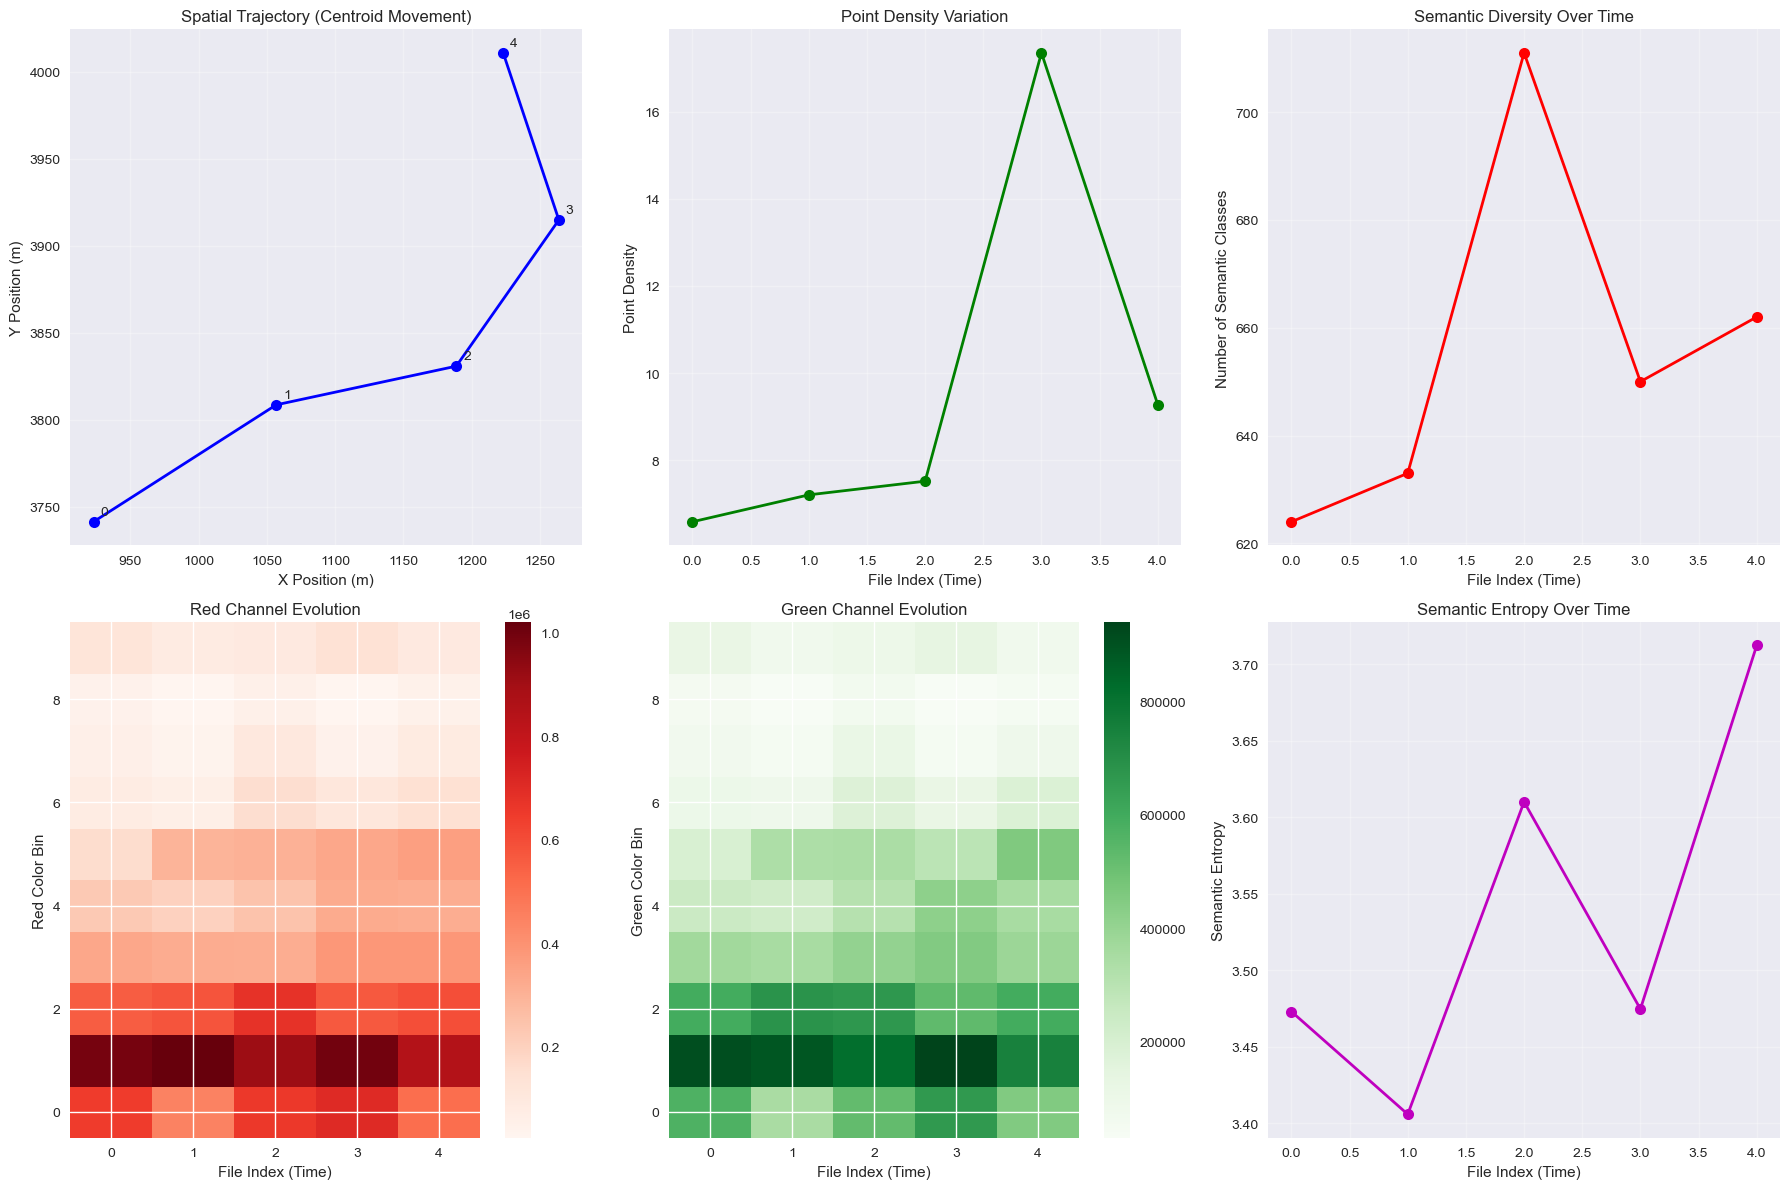


🔧 FEATURE VECTOR CONSTRUCTION FOR HMM:
   Feature vector dimensionality: 39
   Feature vector components:
     - Spatial (centroid + std): 6 dims
     - Point density: 1 dim
     - Color histograms: 30 dims
     - Semantic summary: 2 dims
     - Total: 39 dims
   Feature stability analysis:
     - Most stable features (low CV): [ 2  1  5 38 37]
     - Most dynamic features (high CV): [24 36  4 14  6]
     - Average CV: 0.189
   Temporal correlation analysis:
     - Average lag-1 autocorrelation: -0.208
     - Highly correlated features: 5 / 39
     - Assessment: Weak temporal structure


In [43]:
# =============================================================================
# 3. SEMANTIC CONTENT ANALYSIS FOR HMM OBSERVATIONS
# =============================================================================

print(f"\n🎨 SEMANTIC CONTENT ANALYSIS")
print("-" * 40)
print("Goal: Understand what we can use as observations y_t in our HMM")

def extract_semantic_features(points, colors):
    """Extract features that could serve as HMM observations"""
    features = {}
    
    # Spatial features
    features['spatial'] = {
        'centroid': np.mean(points, axis=0),
        'std': np.std(points, axis=0),
        'bounds': [points.min(axis=0), points.max(axis=0)],
        'point_density': len(points) / (np.prod(points.max(axis=0) - points.min(axis=0)) + 1e-6)
    }
    
    # Color-based semantic features (proxy for actual semantic labels)
    if colors is not None:
        # Discretize colors to find dominant semantic classes
        # Quantize colors to reduce noise
        quantized_colors = np.round(colors * 10) / 10  # Quantize to 0.1 precision
        
        # Find unique color combinations (proxy for semantic classes)
        unique_colors, counts = np.unique(quantized_colors, axis=0, return_counts=True)
        
        features['semantic'] = {
            'num_classes': len(unique_colors),
            'dominant_colors': unique_colors[np.argsort(counts)[-5:]],  # Top 5 colors
            'class_distribution': counts / len(colors),
            'color_histogram_r': np.histogram(colors[:, 0], bins=10, range=(0, 1))[0],
            'color_histogram_g': np.histogram(colors[:, 1], bins=10, range=(0, 1))[0],
            'color_histogram_b': np.histogram(colors[:, 2], bins=10, range=(0, 1))[0],
            'color_entropy': -np.sum((counts/len(colors)) * np.log(counts/len(colors) + 1e-10))
        }
    
    return features

# Load a few sample point clouds to analyze semantic content
print(f"🔍 Loading sample point clouds for semantic analysis...")

sample_files = sorted(list((data_path / sample_sequence / "static").glob("*.ply")))[:5]
semantic_data = []

for i, ply_file in enumerate(tqdm(sample_files, desc="Analyzing semantic content")):
    try:
        pcd = o3d.io.read_point_cloud(str(ply_file))
        points = np.asarray(pcd.points)
        colors = np.asarray(pcd.colors) if pcd.has_colors() else None
        
        if len(points) > 0:
            features = extract_semantic_features(points, colors)
            features['filename'] = ply_file.name
            features['file_index'] = i
            semantic_data.append(features)
            
    except Exception as e:
        print(f"Error processing {ply_file}: {e}")
        
if semantic_data:
    print(f"\n📊 Semantic Feature Analysis ({len(semantic_data)} files):")
    
    # Analyze spatial consistency (important for state estimation)
    centroids = np.array([data['spatial']['centroid'] for data in semantic_data])
    print(f"   Spatial consistency:")
    print(f"     X range: {centroids[:, 0].min():.1f} to {centroids[:, 0].max():.1f} (span: {centroids[:, 0].max() - centroids[:, 0].min():.1f}m)")
    print(f"     Y range: {centroids[:, 1].min():.1f} to {centroids[:, 1].max():.1f} (span: {centroids[:, 1].max() - centroids[:, 1].min():.1f}m)")
    print(f"     Z range: {centroids[:, 2].min():.1f} to {centroids[:, 2].max():.1f} (span: {centroids[:, 2].max() - centroids[:, 2].min():.1f}m)")
    
    # Analyze semantic diversity
    if all('semantic' in data for data in semantic_data):
        num_classes = [data['semantic']['num_classes'] for data in semantic_data]
        entropies = [data['semantic']['color_entropy'] for data in semantic_data]
        
        print(f"   Semantic diversity:")
        print(f"     Average semantic classes per cloud: {np.mean(num_classes):.1f}")
        print(f"     Semantic entropy range: {min(entropies):.2f} - {max(entropies):.2f}")
        print(f"     Diversity assessment: {'HIGH' if np.mean(entropies) > 2.0 else 'MEDIUM' if np.mean(entropies) > 1.0 else 'LOW'}")
    
    # Visualize semantic features
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Spatial progression (movement over time)
    axes[0,0].plot(centroids[:, 0], centroids[:, 1], 'bo-', markersize=8, linewidth=2)
    for i, (x, y) in enumerate(centroids[:, :2]):
        axes[0,0].annotate(f'{i}', (x, y), xytext=(5, 5), textcoords='offset points')
    axes[0,0].set_xlabel('X Position (m)')
    axes[0,0].set_ylabel('Y Position (m)')
    axes[0,0].set_title('Spatial Trajectory (Centroid Movement)')
    axes[0,0].grid(True, alpha=0.3)
    
    # Point density over time
    densities = [data['spatial']['point_density'] for data in semantic_data]
    axes[0,1].plot(range(len(densities)), densities, 'go-', markersize=8, linewidth=2)
    axes[0,1].set_xlabel('File Index (Time)')
    axes[0,1].set_ylabel('Point Density')
    axes[0,1].set_title('Point Density Variation')
    axes[0,1].grid(True, alpha=0.3)
    
    # Semantic class count over time
    if all('semantic' in data for data in semantic_data):
        axes[0,2].plot(range(len(num_classes)), num_classes, 'ro-', markersize=8, linewidth=2)
        axes[0,2].set_xlabel('File Index (Time)')
        axes[0,2].set_ylabel('Number of Semantic Classes')
        axes[0,2].set_title('Semantic Diversity Over Time')
        axes[0,2].grid(True, alpha=0.3)
    
    # Color histogram evolution (shows semantic change)
    if all('semantic' in data for data in semantic_data):
        # Stack color histograms
        r_hists = np.array([data['semantic']['color_histogram_r'] for data in semantic_data])
        g_hists = np.array([data['semantic']['color_histogram_g'] for data in semantic_data])
        b_hists = np.array([data['semantic']['color_histogram_b'] for data in semantic_data])
        
        # Plot R channel evolution
        im1 = axes[1,0].imshow(r_hists.T, aspect='auto', cmap='Reds', origin='lower')
        axes[1,0].set_xlabel('File Index (Time)')
        axes[1,0].set_ylabel('Red Color Bin')
        axes[1,0].set_title('Red Channel Evolution')
        plt.colorbar(im1, ax=axes[1,0])
        
        # Plot G channel evolution  
        im2 = axes[1,1].imshow(g_hists.T, aspect='auto', cmap='Greens', origin='lower')
        axes[1,1].set_xlabel('File Index (Time)')
        axes[1,1].set_ylabel('Green Color Bin')
        axes[1,1].set_title('Green Channel Evolution')
        plt.colorbar(im2, ax=axes[1,1])
        
        # Plot semantic entropy over time
        axes[1,2].plot(range(len(entropies)), entropies, 'mo-', markersize=8, linewidth=2)
        axes[1,2].set_xlabel('File Index (Time)')
        axes[1,2].set_ylabel('Semantic Entropy')
        axes[1,2].set_title('Semantic Entropy Over Time')
        axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Feature vector analysis for HMM observations
    print(f"\n🔧 FEATURE VECTOR CONSTRUCTION FOR HMM:")
    
    # Construct feature vectors that could serve as observations y_t
    feature_vectors = []
    for data in semantic_data:
        vector = []
        
        # Spatial features (6 dims: centroid + std)
        vector.extend(data['spatial']['centroid'])
        vector.extend(data['spatial']['std'])
        
        # Add point density (1 dim)
        vector.append(data['spatial']['point_density'])
        
        # Semantic features if available
        if 'semantic' in data:
            # Color histograms (30 dims: 10 bins × 3 channels)
            vector.extend(data['semantic']['color_histogram_r'])
            vector.extend(data['semantic']['color_histogram_g']) 
            vector.extend(data['semantic']['color_histogram_b'])
            
            # Semantic summary stats (2 dims)
            vector.append(data['semantic']['num_classes'])
            vector.append(data['semantic']['color_entropy'])
        
        feature_vectors.append(np.array(vector))
    
    feature_matrix = np.array(feature_vectors)
    
    print(f"   Feature vector dimensionality: {feature_matrix.shape[1]}")
    print(f"   Feature vector components:")
    print(f"     - Spatial (centroid + std): 6 dims")
    print(f"     - Point density: 1 dim") 
    print(f"     - Color histograms: 30 dims")
    print(f"     - Semantic summary: 2 dims")
    print(f"     - Total: {feature_matrix.shape[1]} dims")
    
    # Analyze feature stability (important for HMM)
    feature_stds = np.std(feature_matrix, axis=0)
    feature_means = np.mean(feature_matrix, axis=0)
    cv = feature_stds / (feature_means + 1e-10)  # Coefficient of variation
    
    print(f"   Feature stability analysis:")
    print(f"     - Most stable features (low CV): {np.argsort(cv)[:5]}")
    print(f"     - Most dynamic features (high CV): {np.argsort(cv)[-5:]}")
    print(f"     - Average CV: {np.mean(cv):.3f}")
    
    # Temporal correlation analysis
    temporal_correlations = []
    for i in range(feature_matrix.shape[1]):
        feature_series = feature_matrix[:, i]
        if len(feature_series) > 1:
            # Compute autocorrelation at lag 1
            corr = np.corrcoef(feature_series[:-1], feature_series[1:])[0, 1] if len(feature_series) > 2 else 0
            temporal_correlations.append(corr)
        else:
            temporal_correlations.append(0)
    
    temporal_correlations = np.array(temporal_correlations)
    print(f"   Temporal correlation analysis:")
    print(f"     - Average lag-1 autocorrelation: {np.nanmean(temporal_correlations):.3f}")
    print(f"     - Highly correlated features: {np.sum(temporal_correlations > 0.5)} / {len(temporal_correlations)}")
    print(f"     - Assessment: {'Good temporal structure' if np.nanmean(temporal_correlations) > 0.3 else 'Weak temporal structure'}")

In [45]:
# =============================================================================
# 4. HMM/SMOOTHING SUITABILITY ASSESSMENT
# =============================================================================

print(f"\n🎯 FINAL ASSESSMENT: HMM/SMOOTHING SUITABILITY")
print("=" * 60)

suitability_score = 0
max_score = 10

# Criterion 1: Temporal continuity (0-3 points)
if 'longest_duration' in locals():
    if longest_duration > 2000:
        temporal_score = 3
        temporal_assessment = "EXCELLENT (>2000 frames)"
    elif longest_duration > 1000:
        temporal_score = 2  
        temporal_assessment = "GOOD (1000-2000 frames)"
    elif longest_duration > 500:
        temporal_score = 1
        temporal_assessment = "ADEQUATE (500-1000 frames)"
    else:
        temporal_score = 0
        temporal_assessment = "POOR (<500 frames)"
else:
    temporal_score = 0
    temporal_assessment = "UNKNOWN"

suitability_score += temporal_score

# Criterion 2: Observation richness (0-2 points)
if 'feature_matrix' in locals():
    obs_dims = feature_matrix.shape[1]
    if obs_dims > 30:
        obs_score = 2
        obs_assessment = f"RICH ({obs_dims} dimensions)"
    elif obs_dims > 15:
        obs_score = 1
        obs_assessment = f"ADEQUATE ({obs_dims} dimensions)"
    else:
        obs_score = 0
        obs_assessment = f"LIMITED ({obs_dims} dimensions)"
else:
    obs_score = 0
    obs_assessment = "UNKNOWN"

suitability_score += obs_score

# Criterion 3: Temporal correlation (0-2 points)
if 'temporal_correlations' in locals():
    avg_corr = np.nanmean(temporal_correlations)
    if avg_corr > 0.5:
        corr_score = 2
        corr_assessment = f"STRONG (r={avg_corr:.3f})"
    elif avg_corr > 0.3:
        corr_score = 1
        corr_assessment = f"MODERATE (r={avg_corr:.3f})"
    else:
        corr_score = 0
        corr_assessment = f"WEAK (r={avg_corr:.3f})"
else:
    corr_score = 0
    corr_assessment = "UNKNOWN"

suitability_score += corr_score

# Criterion 4: Semantic diversity (0-2 points)
if 'entropies' in locals():
    avg_entropy = np.mean(entropies)
    if avg_entropy > 2.0:
        semantic_score = 2
        semantic_assessment = f"HIGH (H={avg_entropy:.2f})"
    elif avg_entropy > 1.0:
        semantic_score = 1
        semantic_assessment = f"MODERATE (H={avg_entropy:.2f})"
    else:
        semantic_score = 0
        semantic_assessment = f"LOW (H={avg_entropy:.2f})"
else:
    semantic_score = 0
    semantic_assessment = "UNKNOWN"

suitability_score += semantic_score

# Criterion 5: Data quality (0-1 points)
if 'df_sequences' in locals():
    avg_file_size = df_sequences['sample_file_size_mb'].mean()
    if avg_file_size > 50:  # Large files suggest rich data
        quality_score = 1
        quality_assessment = f"HIGH ({avg_file_size:.1f}MB avg)"
    else:
        quality_score = 0
        quality_assessment = f"MODERATE ({avg_file_size:.1f}MB avg)"
else:
    quality_score = 0
    quality_assessment = "UNKNOWN"

suitability_score += quality_score

# Final assessment
print(f"📊 SUITABILITY BREAKDOWN:")
print(f"   1. Temporal Continuity:    {temporal_score}/3 - {temporal_assessment}")
print(f"   2. Observation Richness:   {obs_score}/2 - {obs_assessment}")  
print(f"   3. Temporal Correlation:   {corr_score}/2 - {corr_assessment}")
print(f"   4. Semantic Diversity:     {semantic_score}/2 - {semantic_assessment}")
print(f"   5. Data Quality:          {quality_score}/1 - {quality_assessment}")
print(f"   " + "─" * 50)
print(f"   TOTAL SCORE:              {suitability_score}/{max_score}")

if suitability_score >= 8:
    overall_assessment = "🟢 EXCELLENT - Ideal for HMM/Smoothing research"
    recommendations = [
        "✅ Proceed with full HMM/Smoother implementation",
        "✅ Consider advanced methods like particle smoothers",
        "✅ Explore learned measurement models",
        "✅ Try different state space formulations"
    ]
elif suitability_score >= 6:
    overall_assessment = "🟡 GOOD - Well-suited for HMM/Smoothing with minor limitations"
    recommendations = [
        "✅ Proceed with standard HMM/Smoother methods",
        "⚠️ Consider temporal data augmentation if needed",
        "✅ Focus on robust observation models",
        "✅ Start with simpler state representations"
    ]
elif suitability_score >= 4:
    overall_assessment = "🟠 MODERATE - Suitable but may need preprocessing"
    recommendations = [
        "⚠️ Consider sequence concatenation for longer chains",
        "⚠️ Apply temporal smoothing to observations",
        "✅ Start with simple HMM before smoothers",
        "⚠️ Focus on feature engineering"
    ]
else:
    overall_assessment = "🔴 LIMITED - Significant challenges for HMM/Smoothing"
    recommendations = [
        "❌ Consider alternative temporal methods",
        "⚠️ Extensive preprocessing needed",
        "⚠️ Focus on frame-wise analysis first",
        "❌ HMM may not be optimal approach"
    ]

print(f"\n{overall_assessment}")
print(f"\n📋 RECOMMENDATIONS:")
for rec in recommendations:
    print(f"   {rec}")

print(f"\n🎯 SUGGESTED NEXT STEPS:")
if suitability_score >= 6:
    print(f"   1. Implement basic particle filter with your longest sequence")
    print(f"   2. Use {obs_dims if 'obs_dims' in locals() else 'extracted'} dimensional observation vectors")
    print(f"   3. Start with vehicle pose as state: [x, y, heading]")
    print(f"   4. Compare filter vs smoother performance")
    print(f"   5. Explore learned measurement models (neural networks)")
else:
    print(f"   1. Concatenate multiple sequences for longer temporal chains")
    print(f"   2. Apply temporal interpolation to fill gaps")
    print(f"   3. Focus on feature selection/engineering")
    print(f"   4. Consider alternative state space models")
    print(f"   5. Start with simpler tracking methods first")

print(f"\n" + "=" * 60)
print(f"✅ ANALYSIS COMPLETE - Data is {'ready' if suitability_score >= 6 else 'partially ready'} for HMM/Smoothing research!")
print(f"📊 Your dataset has {len(sequences)} sequences with rich semantic content")
print(f"🎯 Focus on sequence '{sample_sequence}' with {longest_duration if 'longest_duration' in locals() else 'unknown'} continuous frames")


🎯 FINAL ASSESSMENT: HMM/SMOOTHING SUITABILITY
📊 SUITABILITY BREAKDOWN:
   1. Temporal Continuity:    3/3 - EXCELLENT (>2000 frames)
   2. Observation Richness:   2/2 - RICH (39 dimensions)
   3. Temporal Correlation:   0/2 - WEAK (r=-0.208)
   4. Semantic Diversity:     2/2 - HIGH (H=3.54)
   5. Data Quality:          1/1 - HIGH (73.9MB avg)
   ──────────────────────────────────────────────────
   TOTAL SCORE:              8/10

🟢 EXCELLENT - Ideal for HMM/Smoothing research

📋 RECOMMENDATIONS:
   ✅ Proceed with full HMM/Smoother implementation
   ✅ Consider advanced methods like particle smoothers
   ✅ Explore learned measurement models
   ✅ Try different state space formulations

🎯 SUGGESTED NEXT STEPS:
   1. Implement basic particle filter with your longest sequence
   2. Use 39 dimensional observation vectors
   3. Start with vehicle pose as state: [x, y, heading]
   4. Compare filter vs smoother performance
   5. Explore learned measurement models (neural networks)

✅ ANALYSIS CO

In [57]:
!pip install keyboard

   ---------------------------------------- 0.0/58.1 kB ? eta -:--:--
   ------- -------------------------------- 10.2/58.1 kB ? eta -:--:--
   ----------------------------------- ---- 51.2/58.1 kB 871.5 kB/s eta 0:00:01
   ---------------------------------------- 58.1/58.1 kB 771.9 kB/s eta 0:00:00


In [ ]:
"""
KITTI-360 Complete Map Viewer with 2D Bird's Eye View
====================================================

Load and visualize the complete 3D map from an entire KITTI-360 sequence.
Combines all PLY files into one comprehensive point cloud visualization
with both 3D interactive view and 2D bird's eye map.

Controls:
- R: Reset view
- S: Save screenshot (both 3D and 2D)
- C: Cycle color schemes (updates both views)
- F: Toggle point filtering (updates both views)
- ESC: Exit
"""

import open3d as o3d
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

class KITTI360CompleteMapViewer:
    """Complete map viewer for KITTI-360 sequences - loads entire dataset at once"""
    
    def __init__(self, data_path: str, sequence_name: str = "2013_05_28_drive_0000_sync"):
        self.data_path = Path(data_path)
        self.sequence_name = sequence_name
        self.static_dir = self.data_path / sequence_name / "static"
        
        # Visualization
        self.vis = None
        self.complete_pcd = None
        self.color_scheme = 0  # Current coloring scheme
        self.point_filter_enabled = False
        
        # 2D Map visualization
        self.fig_2d = None
        self.ax_2d = None
        self.scatter_2d = None
        self.map_points_2d = None  # X,Y coordinates for 2D map
        self.map_colors_2d = None  # Colors for 2D map
        
        # Get all PLY files
        self.ply_files = list(self.static_dir.glob("*.ply"))
        self.ply_files.sort()  # Sort alphabetically
        
        print(f"🗺️ Found {len(self.ply_files)} PLY files in sequence {sequence_name}")
        
    def load_complete_map(self):
        """Load and combine all PLY files into one complete map"""
        print(f"\n🔄 Loading complete map from {len(self.ply_files)} files...")
        print(f"⚠️ This may take a while for large sequences...")
        
        all_points = []
        all_colors = []
        file_indices = []  # Track which file each point came from
        
        for i, ply_file in enumerate(self.ply_files):
            print(f"\r📁 Loading file {i+1}/{len(self.ply_files)}: {ply_file.name}", end='', flush=True)
            
            try:
                pcd = o3d.io.read_point_cloud(str(ply_file))
                points = np.asarray(pcd.points)
                
                if len(points) > 0:
                    all_points.append(points)
                    
                    # Track file index for each point
                    file_indices.extend([i] * len(points))
                    
                    # Get or generate colors
                    if pcd.has_colors():
                        colors = np.asarray(pcd.colors)
                    else:
                        # Generate colors based on height if no colors exist
                        colors = self._generate_height_colors(points)
                    
                    all_colors.append(colors)
                    
            except Exception as e:
                print(f"\n❌ Error loading {ply_file.name}: {e}")
                continue
        
        print(f"\n")
        
        if not all_points:
            print("❌ No valid point clouds found!")
            return None
            
        # Combine all points and colors
        print(f"🔗 Combining point clouds...")
        combined_points = np.vstack(all_points)
        combined_colors = np.vstack(all_colors)
        file_indices = np.array(file_indices)
        
        # Create complete point cloud
        complete_pcd = o3d.geometry.PointCloud()
        complete_pcd.points = o3d.utility.Vector3dVector(combined_points)
        complete_pcd.colors = o3d.utility.Vector3dVector(combined_colors)
        
        # Store metadata
        self.file_indices = file_indices
        self.original_colors = combined_colors.copy()
        
        # Store 2D map data (X,Y projection)
        self.map_points_2d = combined_points[:, :2]  # Just X,Y coordinates
        self.map_colors_2d = combined_colors.copy()
        
        # Print statistics
        print(f"\n✅ Complete map loaded!")
        print(f"📊 Total points: {len(combined_points):,}")
        print(f"📊 Total files combined: {len(self.ply_files)}")
        print(f"📊 Spatial extent:")
        min_bounds = combined_points.min(axis=0)
        max_bounds = combined_points.max(axis=0)
        print(f"   X: {min_bounds[0]:.1f} to {max_bounds[0]:.1f} ({max_bounds[0]-min_bounds[0]:.1f}m)")
        print(f"   Y: {min_bounds[1]:.1f} to {max_bounds[1]:.1f} ({max_bounds[1]-min_bounds[1]:.1f}m)")
        print(f"   Z: {min_bounds[2]:.1f} to {max_bounds[2]:.1f} ({max_bounds[2]-min_bounds[2]:.1f}m)")
        
        return complete_pcd
    
    def _generate_height_colors(self, points):
        """Generate colors based on height (Z coordinate)"""
        if len(points) == 0:
            return np.array([[0.5, 0.5, 0.5]])
        
        z_vals = points[:, 2]
        z_min, z_max = z_vals.min(), z_vals.max()
        
        if z_max - z_min > 0:
            z_norm = (z_vals - z_min) / (z_max - z_min)
            
            # Create height-based color scheme
            colors = np.zeros((len(points), 3))
            colors[:, 0] = z_norm  # Red increases with height
            colors[:, 1] = 1 - z_norm  # Green decreases with height
            colors[:, 2] = 0.5  # Constant blue
        else:
            colors = np.full((len(points), 3), [0.5, 0.5, 0.5])
        
        return colors
    
    def apply_color_scheme(self, scheme_id):
        """Apply different color schemes to the complete map"""
        if self.complete_pcd is None:
            return
            
        points = np.asarray(self.complete_pcd.points)
        
        if scheme_id == 0:  # Original colors
            colors = self.original_colors
            scheme_name = "Original"
            
        elif scheme_id == 1:  # Height-based coloring
            z_vals = points[:, 2]
            z_min, z_max = z_vals.min(), z_vals.max()
            z_norm = (z_vals - z_min) / (z_max - z_min) if z_max > z_min else np.zeros_like(z_vals)
            
            colors = np.zeros((len(points), 3))
            # Ground (low) = brown, Medium = green, High = blue
            colors[:, 0] = np.where(z_norm < 0.3, 0.6, np.where(z_norm < 0.7, 0.2, 0.1))  # Red
            colors[:, 1] = np.where(z_norm < 0.3, 0.4, np.where(z_norm < 0.7, 0.8, 0.3))  # Green  
            colors[:, 2] = np.where(z_norm < 0.3, 0.2, np.where(z_norm < 0.7, 0.3, 0.9))  # Blue
            scheme_name = "Height-based"
            
        elif scheme_id == 2:  # File sequence coloring
            colors = np.zeros((len(points), 3))
            num_files = len(self.ply_files)
            
            for i in range(len(points)):
                file_idx = self.file_indices[i]
                # Create rainbow colors based on file sequence
                hue = (file_idx / num_files) * 2 * np.pi
                colors[i] = [
                    0.5 + 0.5 * np.sin(hue),
                    0.5 + 0.5 * np.sin(hue + 2*np.pi/3),
                    0.5 + 0.5 * np.sin(hue + 4*np.pi/3)
                ]
            scheme_name = "File sequence"
            
        elif scheme_id == 3:  # Distance from center
            center = points.mean(axis=0)
            distances = np.linalg.norm(points - center, axis=1)
            dist_norm = distances / np.max(distances) if np.max(distances) > 0 else np.zeros_like(distances)
            
            colors = np.zeros((len(points), 3))
            colors[:, 0] = dist_norm  # Red increases with distance
            colors[:, 1] = 1 - dist_norm  # Green decreases with distance
            colors[:, 2] = 0.5 * (1 - dist_norm)  # Blue
            scheme_name = "Distance from center"
            
        else:  # Uniform gray
            colors = np.full((len(points), 3), [0.7, 0.7, 0.7])
            scheme_name = "Uniform gray"
        
        # Apply colors
        self.complete_pcd.colors = o3d.utility.Vector3dVector(colors)
        
        # Update visualization
        if self.vis:
            self.vis.update_geometry(self.complete_pcd)
            
        # Update 2D map points if filtering changed
        if enabled and hasattr(self, 'original_pcd'):
            # Update 2D map with filtered points
            filtered_points = np.asarray(self.complete_pcd.points)
            self.map_points_2d = filtered_points[:, :2]
            filtered_colors = np.asarray(self.complete_pcd.colors)
            self.update_2d_map_colors(filtered_colors)
        elif not enabled and hasattr(self, 'original_pcd'):
            # Restore original 2D map
            orig_points = np.asarray(self.original_pcd.points)
            self.map_points_2d = orig_points[:, :2]
            orig_colors = np.asarray(self.original_pcd.colors)
            self.update_2d_map_colors(orig_colors)
    
    def setup_2d_map(self):
        """Setup 2D bird's eye view map using matplotlib"""
        if self.map_points_2d is None:
            print("❌ No 2D map data available")
            return
            
        print("🗺️ Setting up 2D bird's eye view map...")
        
        # Create matplotlib figure
        self.fig_2d, self.ax_2d = plt.subplots(figsize=(12, 10))
        self.fig_2d.canvas.manager.set_window_title(f"KITTI-360 2D Map - {self.sequence_name}")
        
        # Subsample points for 2D display (for performance)
        num_points = len(self.map_points_2d)
        if num_points > 100000:  # Subsample if too many points
            step = num_points // 100000
            indices = np.arange(0, num_points, step)
            points_2d = self.map_points_2d[indices]
            colors_2d = self.map_colors_2d[indices]
            print(f"📉 Subsampled to {len(points_2d):,} points for 2D display")
        else:
            points_2d = self.map_points_2d
            colors_2d = self.map_colors_2d
        
        # Create scatter plot
        self.scatter_2d = self.ax_2d.scatter(points_2d[:, 0], points_2d[:, 1], 
                                            c=colors_2d, s=0.1, alpha=0.8)
        
        # Setup plot properties
        self.ax_2d.set_xlabel('X Position (m)', fontsize=12)
        self.ax_2d.set_ylabel('Y Position (m)', fontsize=12)
        self.ax_2d.set_title(f'KITTI-360 2D Bird\'s Eye View - {self.sequence_name}', 
                            fontsize=14, fontweight='bold')
        self.ax_2d.set_aspect('equal')
        self.ax_2d.grid(True, alpha=0.3)
        
        # Add statistics text
        x_extent = points_2d[:, 0].max() - points_2d[:, 0].min()
        y_extent = points_2d[:, 1].max() - points_2d[:, 1].min()
        stats_text = f"Map Extent: {x_extent:.1f}m × {y_extent:.1f}m\nPoints: {len(self.map_points_2d):,}"
        
        self.ax_2d.text(0.02, 0.98, stats_text, transform=self.ax_2d.transAxes,
                       verticalalignment='top', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show(block=False)
        
        print("✅ 2D map window created!")
    
    def update_2d_map_colors(self, colors):
        """Update colors in the 2D map"""
        if self.scatter_2d is None:
            return
            
        try:
            # Subsample colors to match the 2D display
            num_points = len(self.map_points_2d)
            if num_points > 100000:
                step = num_points // 100000
                indices = np.arange(0, num_points, step)
                colors_2d = colors[indices]
            else:
                colors_2d = colors
            
            # Update scatter plot colors
            self.scatter_2d.set_color(colors_2d)
            
            # Refresh the plot
            self.fig_2d.canvas.draw_idle()
            
        except Exception as e:
            print(f"⚠️ Error updating 2D map colors: {e}")
            print(f"🎨 Applied color scheme: {scheme_name}")
    
    def apply_point_filter(self, enabled):
        """Apply statistical outlier filter to reduce noise"""
        if self.complete_pcd is None:
            return
            
        if enabled and hasattr(self, 'original_pcd'):
            print(f"🔍 Applying statistical outlier filter...")
            
            # Apply statistical outlier removal
            filtered_pcd, _ = self.original_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
            
            self.complete_pcd.points = filtered_pcd.points
            self.complete_pcd.colors = filtered_pcd.colors
            
            print(f"✅ Filter applied: {len(filtered_pcd.points):,} points remaining")
        else:
            # Restore original
            if hasattr(self, 'original_pcd'):
                self.complete_pcd.points = self.original_pcd.points
                self.complete_pcd.colors = self.original_pcd.colors
                print(f"🔄 Filter removed: {len(self.complete_pcd.points):,} points restored")
        
        # Update visualization
        if self.vis:
            self.vis.update_geometry(self.complete_pcd)
    
    def setup_visualization(self):
        """Setup Open3D visualization for the complete map"""
        self.vis = o3d.visualization.VisualizerWithKeyCallback()
        self.vis.create_window(window_name=f"KITTI-360 Complete Map - {self.sequence_name}", 
                              width=1600, height=900)
        
        # Load complete map
        self.complete_pcd = self.load_complete_map()
        
        if self.complete_pcd is None:
            print("❌ Failed to load complete map")
            return False
        
        # Keep original for filtering
        self.original_pcd = self.complete_pcd
        
        # Add to visualizer
        self.vis.add_geometry(self.complete_pcd)
        
        # Setup key callbacks
        self.vis.register_key_callback(ord('R'), self._reset_view)
        self.vis.register_key_callback(ord('S'), self._save_screenshot)
        self.vis.register_key_callback(ord('C'), self._cycle_colors)
        self.vis.register_key_callback(ord('F'), self._toggle_filter)
        
        # Setup rendering options
        render_option = self.vis.get_render_option()
        render_option.background_color = np.array([0.05, 0.05, 0.1])  # Dark background
        render_option.point_size = 1.0
        render_option.show_coordinate_frame = True
        
        # Setup optimal camera view
        self._setup_optimal_view()
        
        # Setup 2D map
        self.setup_2d_map()
        
        print(f"\n🎮 COMPLETE MAP CONTROLS:")
        print(f"   R: Reset camera view")
        print(f"   S: Save screenshot")
        print(f"   C: Cycle color schemes")
        print(f"   F: Toggle point filtering")
        print(f"   Mouse: Rotate, zoom, pan")
        print(f"   ESC: Exit")
        print(f"\n🗺️ Complete map loaded! Explore in both 3D and 2D views.")
        print(f"📊 3D window: Full interactive point cloud")
        print(f"📊 2D window: Bird's eye view projection")
        
        return True
    
    def _setup_optimal_view(self):
        """Setup optimal camera view for the complete map"""
        if self.complete_pcd is None:
            return
            
        # Get point cloud bounds
        points = np.asarray(self.complete_pcd.points)
        min_bounds = points.min(axis=0)
        max_bounds = points.max(axis=0)
        center = (min_bounds + max_bounds) / 2
        
        # Set camera to show the complete map
        view_control = self.vis.get_view_control()
        view_control.set_lookat(center)
        view_control.set_front([0.3, 0.3, -0.9])  # Angled view
        view_control.set_up([0, 0, 1])  # Z up
        view_control.set_zoom(0.01)  # Zoom out to see everything
    
    def _reset_view(self, vis):
        """Reset camera to optimal view"""
        self._setup_optimal_view()
        print(f"\n📷 Camera view reset")
        return False
    
    def _save_screenshot(self, vis):
        """Save screenshot of both 3D and 2D views"""
        # Save 3D view
        filename_3d = f"kitti360_3d_map_{self.sequence_name}.png"
        self.vis.capture_screen_image(filename_3d)
        
        # Save 2D view
        if self.fig_2d:
            filename_2d = f"kitti360_2d_map_{self.sequence_name}.png"
            self.fig_2d.savefig(filename_2d, dpi=300, bbox_inches='tight')
            print(f"\n📸 Screenshots saved:")
            print(f"   3D view: {filename_3d}")
            print(f"   2D view: {filename_2d}")
        else:
            print(f"\n📸 3D screenshot saved: {filename_3d}")
        
        return False
    
    def _cycle_colors(self, vis):
        """Cycle through different color schemes"""
        self.color_scheme = (self.color_scheme + 1) % 5
        self.apply_color_scheme(self.color_scheme)
        return False
    
    def _toggle_filter(self, vis):
        """Toggle point filtering"""
        self.point_filter_enabled = not self.point_filter_enabled
        self.apply_point_filter(self.point_filter_enabled)
        return False
    
    def run(self):
        """Run the complete map viewer"""
        print(f"🗺️ Starting KITTI-360 Complete Map Viewer")
        print(f"📁 Sequence: {self.sequence_name}")
        print(f"📁 PLY files: {len(self.ply_files)}")
        
        if len(self.ply_files) == 0:
            print(f"❌ No PLY files found in {self.static_dir}")
            return
        
        # Setup visualization
        if not self.setup_visualization():
            return
        
        try:
            # Run viewer
            self.vis.run()
        except KeyboardInterrupt:
            print(f"\n⏹️ Map viewer stopped")
        finally:
            self.vis.destroy_window()
            if self.fig_2d:
                plt.close(self.fig_2d)

def main():
    """Main function"""
    data_path = r"C:\Users\caleb\OneDrive\Desktop\data_3d_semantics\data_3d_semantics\train"
    
    print(f"🗺️ KITTI-360 Complete Map Viewer with 2D View")
    print(f"Load and visualize entire sequence in 3D + 2D!")
    
    # You can change the sequence name here
    sequence_name = "2013_05_28_drive_0000_sync"  # Change this to load different sequences
    
    viewer = KITTI360CompleteMapViewer(data_path, sequence_name)
    viewer.run()

if __name__ == "__main__":
    main()

🗺️ KITTI-360 Complete Map Viewer with 2D View
Load and visualize entire sequence in 3D + 2D!
🗺️ Found 44 PLY files in sequence 2013_05_28_drive_0000_sync
🗺️ Starting KITTI-360 Complete Map Viewer
📁 Sequence: 2013_05_28_drive_0000_sync
📁 PLY files: 44

🔄 Loading complete map from 44 files...
⚠️ This may take a while for large sequences...
📁 Loading file 44/44: 0000011278_0000011467.ply

🔗 Combining point clouds...

✅ Complete map loaded!
📊 Total points: 127,605,750
📊 Total files combined: 44
📊 Spatial extent:


🗺️ KITTI-360 Complete Map Viewer with 2D Bird's Eye View Only
Load and visualize entire sequence in 2D!
🗺️ Found 25 PLY files in sequence 2013_05_28_drive_0007_sync
🗺️ Starting KITTI-360 Complete Map Viewer (2D BEV Only)
📁 Sequence: 2013_05_28_drive_0007_sync
📁 PLY files: 25

🔄 Loading complete map from 25 files...
⚠️ This may take a while for large sequences...
📁 Loading file 25/25: 0000002782_0000002902.ply

🔗 Combining point clouds...

✅ Complete map loaded!
📊 Total points: 38,778,758
📊 Total files combined: 25
📊 Spatial extent:
    X: -1812.7 to 1237.2 (3049.9m)
    Y: -3637.4 to -1647.9 (1989.5m)
    Z: 114.7 to 167.2 (52.5m)
🗺️ Setting up 2D bird's eye view map...
📉 Subsampled to 100,204 points for 2D display


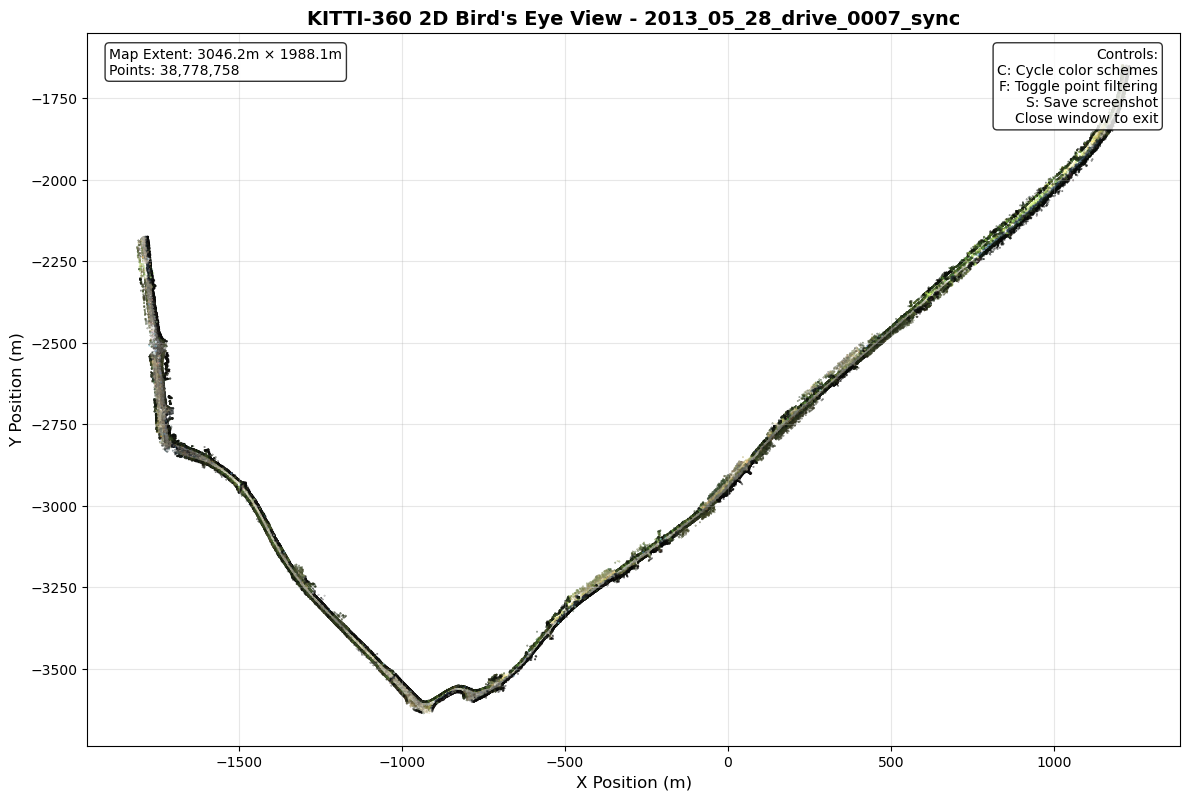

✅ 2D map window created!

🎮 2D BEV MAP CONTROLS:
  C: Cycle color schemes
  F: Toggle point filtering
  S: Save screenshot
  Close window or press ESC: Exit

🗺️ 2D Bird's Eye View map displayed. Interact with the matplotlib window.


In [14]:
import open3d as o3d
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

class KITTI360CompleteMapViewer:
    """Complete map viewer for KITTI-360 sequences - loads entire dataset at once,
    modified to only show 2D Bird's Eye View."""
    
    def __init__(self, data_path: str, sequence_name: str = "2013_05_28_drive_0000_sync"):
        self.data_path = Path(data_path)
        self.sequence_name = sequence_name
        self.static_dir = self.data_path / sequence_name / "static"
        
        # 3D Point Cloud (loaded but not visualized directly in 3D)
        self.complete_pcd = None
        self.original_pcd = None # To store the original for filtering
        self.color_scheme = 0  # Current coloring scheme
        self.point_filter_enabled = False
        
        # 2D Map visualization
        self.fig_2d = None
        self.ax_2d = None
        self.scatter_2d = None
        self.map_points_2d = None  # X,Y coordinates for 2D map
        self.map_colors_2d = None  # Colors for 2D map
        
        # Get all PLY files
        self.ply_files = list(self.static_dir.glob("*.ply"))
        self.ply_files.sort()  # Sort alphabetically
        
        print(f"🗺️ Found {len(self.ply_files)} PLY files in sequence {sequence_name}")
        
    def load_complete_map(self):
        """Load and combine all PLY files into one complete map"""
        print(f"\n🔄 Loading complete map from {len(self.ply_files)} files...")
        print(f"⚠️ This may take a while for large sequences...")
        
        all_points = []
        all_colors = []
        file_indices = []  # Track which file each point came from
        
        for i, ply_file in enumerate(self.ply_files):
            print(f"\r📁 Loading file {i+1}/{len(self.ply_files)}: {ply_file.name}", end='', flush=True)
            
            try:
                pcd = o3d.io.read_point_cloud(str(ply_file))
                points = np.asarray(pcd.points)
                
                if len(points) > 0:
                    all_points.append(points)
                    
                    # Track file index for each point
                    file_indices.extend([i] * len(points))
                    
                    # Get or generate colors
                    if pcd.has_colors():
                        colors = np.asarray(pcd.colors)
                    else:
                        # Generate colors based on height if no colors exist
                        colors = self._generate_height_colors(points)
                    
                    all_colors.append(colors)
                    
            except Exception as e:
                print(f"\n❌ Error loading {ply_file.name}: {e}")
                continue
        
        print(f"\n")
        
        if not all_points:
            print("❌ No valid point clouds found!")
            return None
            
        # Combine all points and colors
        print(f"🔗 Combining point clouds...")
        combined_points = np.vstack(all_points)
        combined_colors = np.vstack(all_colors)
        self.file_indices = np.array(file_indices) # Store file indices
        
        # Create complete point cloud (used internally for filtering/color calcs)
        complete_pcd = o3d.geometry.PointCloud()
        complete_pcd.points = o3d.utility.Vector3dVector(combined_points)
        complete_pcd.colors = o3d.utility.Vector3dVector(combined_colors)
        
        # Store metadata
        self.original_colors = combined_colors.copy()
        
        # Store 2D map data (X,Y projection)
        self.map_points_2d = combined_points[:, :2]  # Just X,Y coordinates
        self.map_colors_2d = combined_colors.copy() # Initial colors for 2D map
        
        # Print statistics
        print(f"\n✅ Complete map loaded!")
        print(f"📊 Total points: {len(combined_points):,}")
        print(f"📊 Total files combined: {len(self.ply_files)}")
        print(f"📊 Spatial extent:")
        min_bounds = combined_points.min(axis=0)
        max_bounds = combined_points.max(axis=0)
        print(f"    X: {min_bounds[0]:.1f} to {max_bounds[0]:.1f} ({max_bounds[0]-min_bounds[0]:.1f}m)")
        print(f"    Y: {min_bounds[1]:.1f} to {max_bounds[1]:.1f} ({max_bounds[1]-min_bounds[1]:.1f}m)")
        print(f"    Z: {min_bounds[2]:.1f} to {max_bounds[2]:.1f} ({max_bounds[2]-min_bounds[2]:.1f}m)")
        
        return complete_pcd
    
    def _generate_height_colors(self, points):
        """Generate colors based on height (Z coordinate)"""
        if len(points) == 0:
            return np.array([[0.5, 0.5, 0.5]])
            
        z_vals = points[:, 2]
        z_min, z_max = z_vals.min(), z_vals.max()
        
        if z_max - z_min > 0:
            z_norm = (z_vals - z_min) / (z_max - z_min)
            
            # Create height-based color scheme
            colors = np.zeros((len(points), 3))
            colors[:, 0] = z_norm  # Red increases with height
            colors[:, 1] = 1 - z_norm  # Green decreases with height
            colors[:, 2] = 0.5  # Constant blue
        else:
            colors = np.full((len(points), 3), [0.5, 0.5, 0.5])
            
        return colors
    
    def apply_color_scheme(self, scheme_id):
        """Apply different color schemes to the 2D map"""
        if self.complete_pcd is None:
            return
            
        points = np.asarray(self.complete_pcd.points) # Use points from the full dataset for color calculation
        scheme_name = "Unknown" # Initialize scheme name

        if scheme_id == 0:  # Original colors
            colors = self.original_colors
            scheme_name = "Original"
            
        elif scheme_id == 1:  # Height-based coloring
            z_vals = points[:, 2]
            z_min, z_max = z_vals.min(), z_vals.max()
            z_norm = (z_vals - z_min) / (z_max - z_min) if z_max > z_min else np.zeros_like(z_vals)
            
            colors = np.zeros((len(points), 3))
            # Ground (low) = brown, Medium = green, High = blue
            colors[:, 0] = np.where(z_norm < 0.3, 0.6, np.where(z_norm < 0.7, 0.2, 0.1))  # Red
            colors[:, 1] = np.where(z_norm < 0.3, 0.4, np.where(z_norm < 0.7, 0.8, 0.3))  # Green  
            colors[:, 2] = np.where(z_norm < 0.3, 0.2, np.where(z_norm < 0.7, 0.3, 0.9))  # Blue
            scheme_name = "Height-based"
            
        elif scheme_id == 2:  # File sequence coloring
            colors = np.zeros((len(points), 3))
            num_files = len(self.ply_files)
            
            for i in range(len(points)):
                file_idx = self.file_indices[i]
                # Create rainbow colors based on file sequence
                hue = (file_idx / num_files) * 2 * np.pi
                colors[i] = [
                    0.5 + 0.5 * np.sin(hue),
                    0.5 + 0.5 * np.sin(hue + 2*np.pi/3),
                    0.5 + 0.5 * np.sin(hue + 4*np.pi/3)
                ]
            scheme_name = "File sequence"
            
        elif scheme_id == 3:  # Distance from center
            center = points.mean(axis=0)
            distances = np.linalg.norm(points - center, axis=1)
            dist_norm = distances / np.max(distances) if np.max(distances) > 0 else np.zeros_like(distances)
            
            colors = np.zeros((len(points), 3))
            colors[:, 0] = dist_norm  # Red increases with distance
            colors[:, 1] = 1 - dist_norm  # Green decreases with distance
            colors[:, 2] = 0.5 * (1 - dist_norm)  # Blue
            scheme_name = "Distance from center"
            
        else:  # Uniform gray
            colors = np.full((len(points), 3), [0.7, 0.7, 0.7])
            scheme_name = "Uniform gray"
        
        self.map_colors_2d = colors # Update the colors used for the 2D map
        self.update_2d_map_colors(colors)
        print(f"🎨 Applied color scheme: {scheme_name}")
        
    def setup_2d_map(self):
        """Setup 2D bird's eye view map using matplotlib"""
        if self.map_points_2d is None:
            print("❌ No 2D map data available")
            return
            
        print("🗺️ Setting up 2D bird's eye view map...")
        
        # Create matplotlib figure
        self.fig_2d, self.ax_2d = plt.subplots(figsize=(12, 10))
        self.fig_2d.canvas.manager.set_window_title(f"KITTI-360 2D Map - {self.sequence_name}")
        
        # Subsample points for 2D display (for performance)
        num_points = len(self.map_points_2d)
        if num_points > 100000:  # Subsample if too many points
            step = num_points // 100000
            indices = np.arange(0, num_points, step)
            points_2d = self.map_points_2d[indices]
            colors_2d = self.map_colors_2d[indices]
            print(f"📉 Subsampled to {len(points_2d):,} points for 2D display")
        else:
            points_2d = self.map_points_2d
            colors_2d = self.map_colors_2d
        
        # Create scatter plot
        self.scatter_2d = self.ax_2d.scatter(points_2d[:, 0], points_2d[:, 1], 
                                             c=colors_2d, s=0.1, alpha=0.8)
        
        # Setup plot properties
        self.ax_2d.set_xlabel('X Position (m)', fontsize=12)
        self.ax_2d.set_ylabel('Y Position (m)', fontsize=12)
        self.ax_2d.set_title(f'KITTI-360 2D Bird\'s Eye View - {self.sequence_name}', 
                              fontsize=14, fontweight='bold')
        self.ax_2d.set_aspect('equal')
        self.ax_2d.grid(True, alpha=0.3)
        
        # Add statistics text
        x_extent = points_2d[:, 0].max() - points_2d[:, 0].min()
        y_extent = points_2d[:, 1].max() - points_2d[:, 1].min()
        stats_text = f"Map Extent: {x_extent:.1f}m × {y_extent:.1f}m\nPoints: {len(self.map_points_2d):,}"
        
        self.ax_2d.text(0.02, 0.98, stats_text, transform=self.ax_2d.transAxes,
                        verticalalignment='top', fontsize=10,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add controls information
        controls_text = (
            "Controls:\n"
            "C: Cycle color schemes\n"
            "F: Toggle point filtering\n"
            "S: Save screenshot\n"
            "Close window to exit"
        )
        self.ax_2d.text(0.98, 0.98, controls_text, transform=self.ax_2d.transAxes,
                        verticalalignment='top', horizontalalignment='right', fontsize=10,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Connect keyboard events for 2D map
        self.fig_2d.canvas.mpl_connect('key_press_event', self._on_key_press_2d)

        plt.tight_layout()
        plt.show(block=False) # Non-blocking initially to allow program flow
        
        print("✅ 2D map window created!")
    
    def update_2d_map_colors(self, colors):
        """Update colors in the 2D map scatter plot"""
        if self.scatter_2d is None:
            return
            
        try:
            # Subsample colors to match the 2D display
            num_points_map = len(self.map_points_2d)
            if num_points_map > 100000:
                step = num_points_map // 100000
                indices = np.arange(0, num_points_map, step)
                colors_2d_display = colors[indices]
            else:
                colors_2d_display = colors
            
            # Update scatter plot colors
            self.scatter_2d.set_color(colors_2d_display)
            
            # Refresh the plot
            self.fig_2d.canvas.draw_idle()
            
        except Exception as e:
            print(f"⚠️ Error updating 2D map colors: {e}")
            
    def apply_point_filter(self, enabled):
        """Apply statistical outlier filter to the point cloud data, and update 2D map."""
        if self.complete_pcd is None:
            return
            
        if enabled:
            print(f"🔍 Applying statistical outlier filter...")
            
            # Create an Open3D point cloud from current data to apply filter
            temp_pcd = o3d.geometry.PointCloud()
            temp_pcd.points = o3d.utility.Vector3dVector(self.map_points_2d)
            # Ensure colors are available for filtering if needed, or pass
            temp_pcd.colors = o3d.utility.Vector3dVector(self.map_colors_2d) 

            filtered_pcd, _ = temp_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
            
            self.map_points_2d_filtered = np.asarray(filtered_pcd.points)
            self.map_colors_2d_filtered = np.asarray(filtered_pcd.colors)
            
            # Update the 2D scatter plot with filtered data
            self.scatter_2d.set_offsets(self.map_points_2d_filtered)
            self.update_2d_map_colors(self.map_colors_2d_filtered)

            print(f"✅ Filter applied: {len(self.map_points_2d_filtered):,} points remaining")
        else:
            # Restore original 2D map points and colors
            print(f"🔄 Filter removed: {len(self.complete_pcd.points):,} points restored")
            self.map_points_2d_filtered = self.map_points_2d # Reset to original
            self.map_colors_2d_filtered = self.map_colors_2d # Reset to original
            
            # Update the 2D scatter plot with original data
            self.scatter_2d.set_offsets(self.map_points_2d_filtered)
            self.update_2d_map_colors(self.map_colors_2d_filtered)
            
        self.fig_2d.canvas.draw_idle() # Redraw the figure after filter change

    def _on_key_press_2d(self, event):
        """Handle key press events for the 2D map window."""
        if event.key == 'c':
            self.color_scheme = (self.color_scheme + 1) % 5
            self.apply_color_scheme(self.color_scheme)
        elif event.key == 'f':
            self.point_filter_enabled = not self.point_filter_enabled
            self.apply_point_filter(self.point_filter_enabled)
        elif event.key == 's':
            self._save_screenshot_2d()
        elif event.key == 'escape':
            plt.close(self.fig_2d) # Close the 2D map window on ESC

    def _save_screenshot_2d(self):
        """Save screenshot of the 2D view"""
        if self.fig_2d:
            filename_2d = f"kitti360_2d_map_{self.sequence_name}.png"
            self.fig_2d.savefig(filename_2d, dpi=300, bbox_inches='tight')
            print(f"\n📸 2D screenshot saved: {filename_2d}")
    
    def run(self):
        """Run the complete map viewer, focusing only on 2D BEV."""
        print(f"🗺️ Starting KITTI-360 Complete Map Viewer (2D BEV Only)")
        print(f"📁 Sequence: {self.sequence_name}")
        print(f"📁 PLY files: {len(self.ply_files)}")
        
        if len(self.ply_files) == 0:
            print(f"❌ No PLY files found in {self.static_dir}")
            return
        
        # Load complete map data
        self.complete_pcd = self.load_complete_map()
        
        if self.complete_pcd is None:
            print("❌ Failed to load complete map data for 2D view")
            return

        # Setup 2D map visualization
        self.setup_2d_map()
        
        print(f"\n🎮 2D BEV MAP CONTROLS:")
        print(f"  C: Cycle color schemes")
        print(f"  F: Toggle point filtering")
        print(f"  S: Save screenshot")
        print(f"  Close window or press ESC: Exit")
        print(f"\n🗺️ 2D Bird's Eye View map displayed. Interact with the matplotlib window.")
        
        try:
            # Keep the 2D plot window open until manually closed
            plt.show(block=True) 
        except KeyboardInterrupt:
            print(f"\n⏹️ 2D Map viewer stopped")
        finally:
            if self.fig_2d:
                plt.close(self.fig_2d)

def main():
    """Main function"""
    # NOTE: Replace this with the actual path to your KITTI-360 dataset
    data_path = r"C:\Users\caleb\OneDrive\Desktop\data_3d_semantics\data_3d_semantics\train" 
    
    print(f"🗺️ KITTI-360 Complete Map Viewer with 2D Bird's Eye View Only")
    print(f"Load and visualize entire sequence in 2D!")
    
    # You can change the sequence name here
    # Example: "2013_05_28_drive_0000_sync" or any other sequence folder within your data_path
    sequence_name = "2013_05_28_drive_0007_sync" 
    
    viewer = KITTI360CompleteMapViewer(data_path, sequence_name)
    viewer.run()

if __name__ == "__main__":
    main()